### Problem Statement
Using the Abuse Analyzer Dataset, in this project, we will try and develop few machine learning algorithms for
text classification. <br>
##### Task involved in this project are:
1. Choose and implement a text representation technique (such as a bag of words, word
embeddings etc.). 
2. Using the text representation from (1), build a machine learning model for text classification
(e.g. decision tree, neural network etc.).
3. Evaluate the model perfromance using the appropriate metrics of our choice.

In [1]:
### All necessary imports
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

import gensim
from xgboost import XGBClassifier

from tqdm import tqdm 
tqdm.pandas(desc="progress-bar") 
from gensim.models.doc2vec import TaggedDocument


import warnings
warnings.filterwarnings('ignore')

In [117]:
dataset = pd.read_csv("AbuseAnalyzer_Dataset.csv")

In [118]:
dataset.head()

,Post Text,Emoji,Hate/Non-Hate,Target of Hate,Class of Hate
0,ALS AT RED BLACKS LIVE RIGHT NOW!,NaN,1,NaN,NaN
1,Rigged election will cause civil war just my o...,NaN,1,NaN,NaN
2,I fucking love it ! Sorry I can only offer him...,NaN,2,1-3,1.0
3,What a steaming load of shit! https://help.tw...,NaN,2,2,1.0
4,Until he does rule it out. The man fucking fli...,NaN,2,1-3,1.0


In [119]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7601 entries, 0 to 7600
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Post Text       7601 non-null   object 
 1   Emoji           121 non-null    object 
 2   Hate/Non-Hate   7601 non-null   int64  
 3   Target of Hate  4120 non-null   object 
 4   Class of Hate   4120 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 297.0+ KB


### Preprocessing the dataset

#### Remove unnecessary column/s

In [120]:
dataset = dataset.drop(['Emoji'], axis = 1)

In [121]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7601 entries, 0 to 7600
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Post Text       7601 non-null   object 
 1   Hate/Non-Hate   7601 non-null   int64  
 2   Target of Hate  4120 non-null   object 
 3   Class of Hate   4120 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 237.7+ KB


In [122]:
dataset['Target of Hate'].unique()

array([nan, '1-3', '2', '1-2'], dtype=object)

### Labels Preprocessing

In [123]:
# Column Labels

dataset['Target of Hate'] = dataset['Target of Hate'].map( {'1-2': 'Individual Second Person',
                               '1-3' : 'Individual Third Person',
                               '2' : 'Group'})
dataset['Target of Hate'] = dataset['Target of Hate'].fillna('Non-Hateful')
dataset['Class of Hate'] = dataset['Class of Hate'].map( {1: 'Biased Attitude',
                               2 : 'Act of Bias and Discrimination',
                               3 : 'Violence and Genocide'})
dataset['Class of Hate'] = dataset['Class of Hate'].fillna('Non-Hateful')

In [124]:
dataset

,Post Text,Hate/Non-Hate,Target of Hate,Class of Hate
0,ALS AT RED BLACKS LIVE RIGHT NOW!,1,Non-Hateful,Non-Hateful
1,Rigged election will cause civil war just my o...,1,Non-Hateful,Non-Hateful
2,I fucking love it ! Sorry I can only offer him...,2,Individual Third Person,Biased Attitude
3,What a steaming load of shit! https://help.tw...,2,Group,Biased Attitude
4,Until he does rule it out. The man fucking fli...,2,Individual Third Person,Biased Attitude
...,...,...,...,...
7596,I am calling for everyone to surround Mikes re...,1,Non-Hateful,Non-Hateful
7597,LMFAO he was going hit the chic tell realized ...,2,Group,Act of Bias and Discrimination
7598,Amazing how Ann got so much wrong.,2,Individual Third Person,Biased Attitude
7599,lol little Anthony drew attention to himself.....,1,Non-Hateful,Non-Hateful


### Understanding Dataset

<AxesSubplot:>

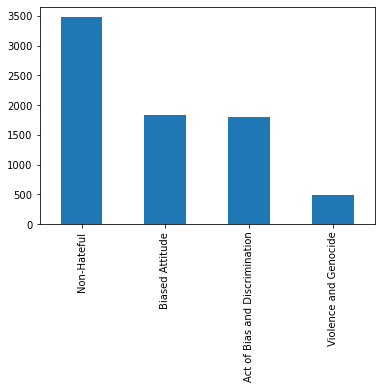

In [125]:
pd.value_counts(dataset['Class of Hate']).plot.bar()

<AxesSubplot:>

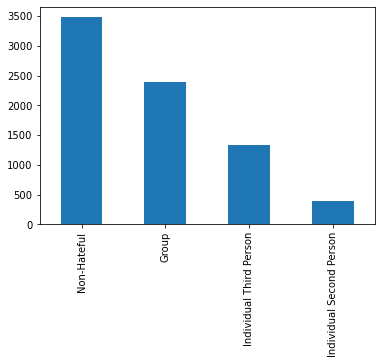

In [126]:
pd.value_counts(dataset['Target of Hate']).plot.bar()

### Text Cleaning

In [127]:
dataset['Post Text'] = dataset['Post Text'].str.lower()
dataset['Post Text'] = [re.sub('[^\w\s]+', '', s) for s in dataset['Post Text']]
dataset['Post Text'] = [re.sub(r'\d\S+'," ", s) for s in dataset['Post Text']]
dataset['Post Text'] = [re.sub(r"http\S+", " ", s) for s in dataset['Post Text']]
dataset['Post Text'] = [re.sub(r'www\S+', " ", s) for s in dataset['Post Text']]
dataset['Post Text'] = [re.sub(r'\.|/|:|-', " ", s) for s in dataset['Post Text']]
dataset['Post Text'] = [re.sub(r'[^\w\s]','', s) for s in dataset['Post Text']]
dataset.head()

,Post Text,Hate/Non-Hate,Target of Hate,Class of Hate
0,als at red blacks live right now,1,Non-Hateful,Non-Hateful
1,rigged election will cause civil war just my o...,1,Non-Hateful,Non-Hateful
2,i fucking love it sorry i can only offer him ...,2,Individual Third Person,Biased Attitude
3,what a steaming load of shit,2,Group,Biased Attitude
4,until he does rule it out the man fucking flip...,2,Individual Third Person,Biased Attitude


### Tokenizing the sentences

In [128]:
tokens = dataset['Post Text'].apply(lambda x: x.split()) # tokenizing 

### Generate Word Embeddings

In [129]:
def labelizer(tkns):
    li = []
    for i, s in zip(tkns.index, tkns):
        li.append(TaggedDocument(s, ["comment_" + str(i)]))
    return li

labelled_comments = labelizer(tokens)

In [130]:
labelled_comments

[TaggedDocument(words=['als', 'at', 'red', 'blacks', 'live', 'right', 'now'], tags=['comment_0']),
 TaggedDocument(words=['rigged', 'election', 'will', 'cause', 'civil', 'war', 'just', 'my', 'opinion'], tags=['comment_1']),
 TaggedDocument(words=['i', 'fucking', 'love', 'it', 'sorry', 'i', 'can', 'only', 'offer', 'him', 'a', 'job', 'as', 'a', 'union', 'laborer'], tags=['comment_2']),
 TaggedDocument(words=['what', 'a', 'steaming', 'load', 'of', 'shit'], tags=['comment_3']),
 TaggedDocument(words=['until', 'he', 'does', 'rule', 'it', 'out', 'the', 'man', 'fucking', 'flip', 'flops', 'on', 'everything'], tags=['comment_4']),
 TaggedDocument(words=['at', 'least', 'im', 'not', 'a', 'dem'], tags=['comment_5']),
 TaggedDocument(words=['anyone', 'who', 'wants', 'to', 'be', 'a', 'ceo', 'in', 'california', 'can', 'do', 'a', 'gender', 'switch', 'then', 'switch', 'back'], tags=['comment_6']),
 TaggedDocument(words=['no', 'muslims', 'attacked', 'us'], tags=['comment_7']),
 TaggedDocument(words=['do

In [131]:
%%time 
vectorSize = 200
embed_model = gensim.models.Doc2Vec(
                                  vector_size= vectorSize,
                                  window=5,                                 
                                  negative=3, 
                                  min_count=5,                              
                                  workers=16,                               
                                  alpha=0.05,
                                  dm=1,
                                  dm_mean=1, 
                                  seed = 42,
                                 )
embed_model.build_vocab([i for i in tqdm(labelled_comments)])

embed_model.train(labelled_comments, total_examples= len(dataset['Post Text']), epochs=30)

100%|█████████████████████████████████████████████████████████████████████████| 7601/7601 [00:00<00:00, 3802135.33it/s]


Wall time: 14.3 s


In [132]:
embed_vectors = np.zeros((len(tokens), vectorSize)) 
for i in range(len(dataset)):
    embed_vectors[i,:] = embed_model.docvecs[i].reshape((1,vectorSize))    

embed_vectors_df = pd.DataFrame(embed_vectors) 
embed_vectors_df.shape

(7601, 200)

In [133]:
embed_vectors_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.129684,0.053766,0.096624,-0.004825,0.004598,0.067261,0.072090,0.072882,-0.079483,0.048536,...,-0.128374,0.091483,0.088557,-0.305041,0.031739,-0.042953,0.058127,0.019518,0.048429,0.028735
1,0.014411,0.074906,-0.086302,-0.081881,-0.047728,0.094691,-0.021658,-0.025495,0.029209,0.096024,...,0.081885,-0.027337,0.160427,-0.175051,-0.065861,-0.010235,0.048658,-0.053472,0.049115,0.075771
2,0.092547,0.133217,0.010631,0.079684,-0.061708,-0.109767,0.159563,0.145201,-0.001583,0.196544,...,-0.205589,0.255475,0.049716,-0.006073,-0.014579,-0.203948,-0.017051,0.178243,-0.175357,0.062490
3,0.096196,0.080288,-0.023089,0.005085,-0.045913,0.015015,-0.040113,-0.034105,0.017248,0.042883,...,-0.118244,0.014328,-0.026529,-0.071726,0.066767,-0.016887,-0.033294,-0.013492,0.005515,0.003831
4,0.272220,0.047160,-0.165294,0.033636,0.140712,-0.000177,-0.017635,0.070071,0.263823,0.041250,...,-0.015744,0.154224,0.246361,-0.064986,0.087615,0.089982,-0.021932,0.224538,-0.014050,-0.034463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7596,0.159000,-0.153023,-0.171731,-0.069618,0.029181,-0.073469,0.020098,0.043519,0.047440,0.005053,...,0.025113,-0.010063,0.043045,0.026633,-0.007579,0.014719,-0.080878,0.211880,0.025442,-0.129066
7597,0.173045,0.069832,-0.006802,0.050234,-0.124851,-0.159549,0.035160,0.197984,0.056773,0.032711,...,0.033875,0.108905,0.238691,-0.053766,-0.035950,-0.118219,-0.111345,-0.214916,-0.198872,-0.014088
7598,0.281628,-0.001131,0.041031,0.036708,0.004862,0.007637,0.055149,0.199947,-0.126602,-0.010202,...,-0.164319,0.161944,0.195471,-0.098736,-0.007616,-0.118697,0.100713,0.105757,-0.054967,0.024513
7599,0.068987,-0.015978,-0.005007,0.014188,0.131572,0.023635,-0.016423,0.019615,-0.074136,-0.099927,...,0.014203,-0.050861,0.126285,-0.028922,0.073837,-0.034896,0.122697,-0.011261,0.099402,-0.008343


## Classifier-1 for "Target of Hate" Label

In [43]:
df1 = pd.concat([embed_vectors_df, dataset['Target of Hate']], axis=1)
df1 = df1.sample(frac=1).reset_index(drop=True) ## Shuffle before splitting

In [44]:

# encode string class values as integers
label_encoder = LabelEncoder()
df1['Target of Hate'] = label_encoder.fit_transform(df1['Target of Hate'])
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'Group': 0, 'Individual Second Person': 1, 'Individual Third Person': 2, 'Non-Hateful': 3}


In [45]:
# label_encoder.classes_

In [46]:
X_train,X_test,y_train,y_test = train_test_split(df1.drop(['Target of Hate'], axis = 1),df1['Target of Hate'],test_size=0.2)

In [47]:
print("Number of Samples in Training Dataset : " , X_train.shape[0])
print("Number of Samples in Testing Dataset : " , X_test.shape[0])

Number of Samples in Training Dataset :  6080
Number of Samples in Testing Dataset :  1521


In [48]:
xgb_model = XGBClassifier(max_depth=8, n_estimators=300, verbosity = 2, n_jobs = -1 ) # 
xgb_model.fit(X_train, y_train)

[17:58:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=8
[17:58:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=8
[17:58:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 322 extra nodes, 0 pruned nodes, max_depth=8
[17:58:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 324 extra nodes, 0 pruned nodes, max_depth=8
[17:58:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 330 extra nodes, 0 pruned nodes, max_depth=8
[17:58:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 186 extra nod

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [49]:
predictions = xgb_model.predict(X_test)

In [50]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 61.14%


In [51]:
f1_score(y_test, predictions,  average='micro')

0.611439842209073

In [55]:
# from sklearn.metrics import plot_confusion_matrix

# plot_confusion_matrix(xgb_model, X_test, y_test)
import seaborn as sns

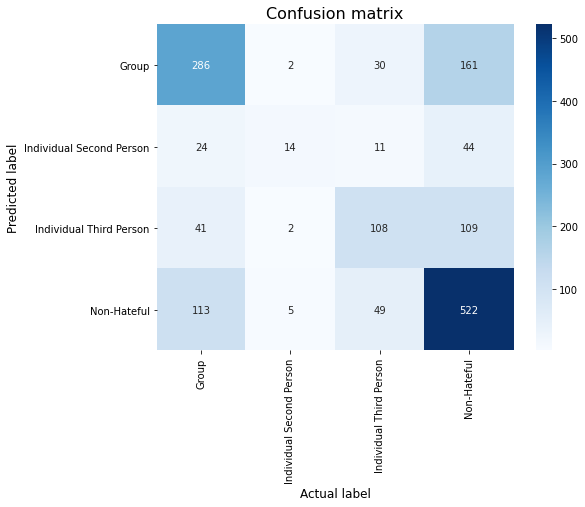

In [56]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Group','Individual Second Person','Individual Third Person','Non-Hateful']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(xgb_model, X_test, y_test)

In [59]:
from sklearn.metrics import classification_report
target_names = ['Group', 'Individual Second Person', 'Individual Third Person', 'Non-Hateful']
print(classification_report(y_test, predictions, target_names=target_names))

                          precision    recall  f1-score   support

                   Group       0.62      0.60      0.61       479
Individual Second Person       0.61      0.15      0.24        93
 Individual Third Person       0.55      0.42      0.47       260
             Non-Hateful       0.62      0.76      0.68       689

                accuracy                           0.61      1521
               macro avg       0.60      0.48      0.50      1521
            weighted avg       0.61      0.61      0.60      1521



### Hyper-parametrs Tuning

In [107]:
estimator = XGBClassifier()
parameters = {
    'max_depth': range(6,10,1),
    'n_estimators': range(800,1000,100),
    'learning_rate': [0.1,0.01,0.05]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    verbose=2,
    cv = 4,
    n_jobs = -1
)
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[19:11:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:11:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[19:11:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:11:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:11:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:11:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/sr

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                  

In [108]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=800,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [60]:
xgb_model = XGBClassifier(learning_rate=0.1, max_depth = 6, n_estimators=800,  verbosity = 2) # max_depth=6, n_estimators=1000
xgb_model.fit(X_train, y_train)

[18:02:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:02:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:02:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:02:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:02:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:02:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=800,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

Accuracy: 61.34%


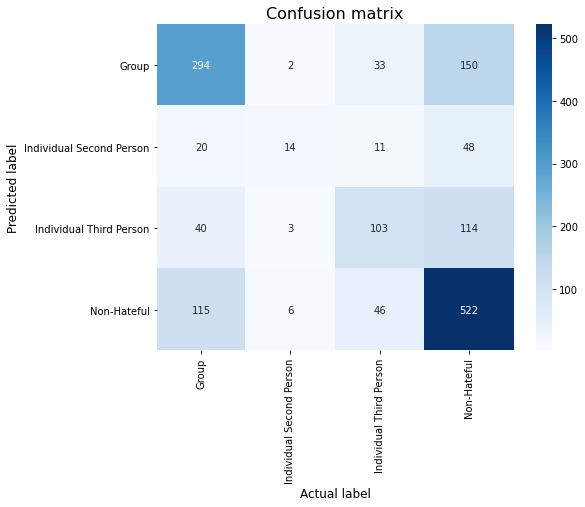

In [61]:
predictions = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
plot_confusion_matrix(xgb_model, X_test, y_test)

In [62]:
from sklearn.metrics import classification_report
target_names = ['Group', 'Individual Second Person', 'Individual Third Person', 'Non-Hateful']
print(classification_report(y_test, predictions, target_names=target_names))

                          precision    recall  f1-score   support

                   Group       0.63      0.61      0.62       479
Individual Second Person       0.56      0.15      0.24        93
 Individual Third Person       0.53      0.40      0.45       260
             Non-Hateful       0.63      0.76      0.69       689

                accuracy                           0.61      1521
               macro avg       0.59      0.48      0.50      1521
            weighted avg       0.61      0.61      0.60      1521



## Classifier-2 for "Class of Hate" Label

In [134]:
df2 = pd.concat([embed_vectors_df, dataset['Class of Hate']], axis=1)
df2 = df2.sample(frac=1).reset_index(drop=True) ## Shuffle before splitting

In [135]:
df2

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Class of Hate
0,0.063077,0.011474,-0.140052,-0.005730,-0.004124,-0.016974,0.084696,0.082288,0.015598,0.104915,...,0.209753,0.176574,-0.179319,0.019382,0.064075,0.005295,-0.132358,-0.019412,0.002292,Non-Hateful
1,0.119953,-0.028843,0.056651,-0.047872,0.047238,-0.035173,0.036703,0.130678,-0.080508,-0.095446,...,0.024597,0.121563,-0.083890,0.086082,-0.124573,0.057682,0.205727,0.003608,0.016983,Non-Hateful
2,0.195441,-0.148330,-0.003543,0.078520,-0.078260,-0.002058,-0.051031,0.054056,-0.024381,0.099141,...,0.066219,-0.066181,-0.081652,-0.064801,0.086143,0.042900,0.055446,0.108012,-0.154670,Act of Bias and Discrimination
3,-0.007655,0.029486,0.010480,0.050572,0.027878,-0.003573,0.090609,0.031402,-0.010886,0.028279,...,0.177871,-0.017277,-0.279987,0.028539,0.086064,-0.005670,-0.017149,0.015563,-0.181611,Act of Bias and Discrimination
4,0.156450,0.008508,0.028008,-0.014996,-0.048815,-0.050680,-0.055340,-0.005252,-0.164476,-0.065979,...,0.074259,-0.001695,-0.150675,0.088775,-0.052021,0.053196,0.153713,0.044566,-0.040430,Non-Hateful
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7596,0.014654,-0.145158,-0.078904,0.079235,-0.106088,0.030006,-0.147795,0.149314,-0.111516,-0.016507,...,0.137522,0.138592,0.022743,-0.080134,-0.162055,-0.159978,0.119074,0.162867,0.019467,Biased Attitude
7597,0.293801,-0.073542,-0.109984,0.024702,-0.174088,-0.090018,-0.164465,0.101470,-0.196775,0.126998,...,0.038243,0.075902,-0.256274,0.038226,-0.037679,-0.223477,0.166518,0.025416,0.011905,Biased Attitude
7598,-0.017393,0.013183,0.021968,-0.018078,-0.056216,-0.159204,0.019080,0.034652,-0.004702,-0.039642,...,-0.079803,0.047957,-0.078544,0.136402,-0.125195,0.074728,0.032462,-0.020450,0.130664,Biased Attitude
7599,0.178325,0.019924,0.151436,0.106691,-0.134761,0.040142,-0.060787,0.076101,-0.103845,-0.010540,...,0.235315,-0.110962,0.031766,0.080555,-0.166842,0.097310,0.127226,0.004074,0.141637,Non-Hateful


In [136]:
# encode string class values as integers
label_encoder = LabelEncoder()
df2['Class of Hate'] = label_encoder.fit_transform(df2['Class of Hate'])
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'Act of Bias and Discrimination': 0, 'Biased Attitude': 1, 'Non-Hateful': 2, 'Violence and Genocide': 3}


In [137]:
X_train,X_test,y_train,y_test = train_test_split(df2.drop(['Class of Hate'], axis = 1),df2['Class of Hate'],test_size=0.2)
print("Number of Samples in Training Dataset : " , X_train.shape[0])
print("Number of Samples in Testing Dataset : " , X_test.shape[0])


Number of Samples in Training Dataset :  6080
Number of Samples in Testing Dataset :  1521


In [138]:
xgb_model = XGBClassifier(max_depth=9, n_estimators=2000, verbosity = 2 ) # 
xgb_model.fit(X_train, y_train)

[19:18:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 420 extra nodes, 0 pruned nodes, max_depth=9
[19:18:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=9
[19:18:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 450 extra nodes, 0 pruned nodes, max_depth=9
[19:18:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=9
[19:18:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 466 extra nodes, 0 pruned nodes, max_depth=9
[19:18:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 410 extra nod

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=2000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

Accuracy: 53.45%


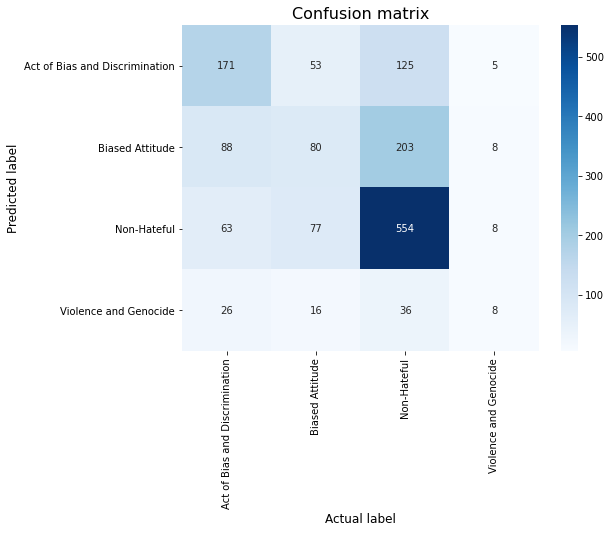

In [139]:
predictions = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Act of Bias and Discrimination', 'Biased Attitude', 'Non-Hateful', 'Violence and Genocide']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    


plot_confusion_matrix(xgb_model, X_test, y_test)

In [140]:
from sklearn.metrics import classification_report
target_names = ['Act of Bias and Discrimination', 'Biased Attitude', 'Non-Hateful', 'Violence and Genocide']
print(classification_report(y_test, predictions, target_names=target_names))

                                precision    recall  f1-score   support

Act of Bias and Discrimination       0.49      0.48      0.49       354
               Biased Attitude       0.35      0.21      0.26       379
                   Non-Hateful       0.60      0.79      0.68       702
         Violence and Genocide       0.28      0.09      0.14        86

                      accuracy                           0.53      1521
                     macro avg       0.43      0.39      0.39      1521
                  weighted avg       0.50      0.53      0.50      1521



In [141]:
df3 = pd.concat([embed_vectors_df, dataset['Class of Hate']], axis=1)
df3 = df3.sample(frac=1).reset_index(drop=True) ## Shuffle before splitting

In [142]:
df3['Class of Hate'].value_counts()

Non-Hateful                       3481
Biased Attitude                   1830
Act of Bias and Discrimination    1807
Violence and Genocide              483
Name: Class of Hate, dtype: int64

In [143]:
df4 = df3[df3['Class of Hate'] == "Non-Hateful"].iloc[:500]
df4 = pd.concat([df4, df3[df3['Class of Hate'] == "Biased Attitude"].iloc[:500]], axis = 0 )
df4 = pd.concat([df4, df3[df3['Class of Hate'] == "Act of Bias and Discrimination"].iloc[:500]], axis = 0 )
df4 = pd.concat([df4, df3[df3['Class of Hate'] == "Violence and Genocide"]], axis = 0 )
df4 = df4.sample(frac=1).reset_index(drop=True)

In [144]:
df4

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Class of Hate
0,0.150074,0.025227,-0.044364,0.024114,0.025425,-0.039421,0.050629,0.109437,-0.009873,-0.051370,...,0.073474,0.149640,-0.021376,-0.050199,-0.086915,0.074803,0.042393,-0.100959,0.014103,Non-Hateful
1,-0.441934,0.067745,0.082750,-0.080902,-0.142099,-0.043717,0.102041,-0.051229,0.033298,0.051447,...,-0.171261,-0.335000,-0.037024,0.152230,0.195818,0.141303,-0.396940,-0.579758,-0.208693,Biased Attitude
2,0.129902,-0.051896,0.049154,0.114776,-0.040203,0.124739,0.066614,0.047152,0.008755,0.062469,...,0.034805,-0.062776,0.056792,0.032752,-0.068995,0.079842,0.034160,-0.112533,-0.106969,Biased Attitude
3,0.087430,-0.019803,-0.044425,0.020135,0.069105,-0.027029,0.026596,0.154303,-0.038471,-0.029641,...,-0.004799,0.155286,-0.079272,-0.100697,-0.087699,-0.009758,-0.015085,-0.100040,-0.099852,Non-Hateful
4,0.008834,0.067391,-0.133499,0.079121,-0.146663,-0.041916,0.131252,0.201985,-0.263911,-0.281454,...,-0.040564,-0.179605,-0.212561,0.331342,0.046608,-0.063264,0.007188,-0.037970,-0.056734,Act of Bias and Discrimination
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1978,-0.035206,-0.040945,0.145369,-0.138359,-0.002065,0.074994,-0.021006,0.167575,0.005885,0.049640,...,0.061549,0.144765,-0.088680,-0.097030,-0.158188,-0.228903,0.009602,-0.078740,0.134754,Act of Bias and Discrimination
1979,-0.069561,-0.049474,0.043571,0.083479,-0.067750,0.085417,0.011486,-0.015690,0.001473,-0.022293,...,0.074806,-0.016910,0.068314,-0.131311,0.167755,0.066085,0.084326,0.078105,0.012231,Act of Bias and Discrimination
1980,0.119172,-0.009405,-0.027860,-0.020730,0.143725,-0.084606,0.066616,0.229848,0.028734,-0.201643,...,0.121614,0.407459,-0.080871,-0.108852,-0.199078,-0.124122,0.010208,-0.289831,-0.028693,Violence and Genocide
1981,0.027448,0.035291,0.017185,-0.046054,-0.020150,-0.070146,0.051075,0.063954,-0.030131,-0.027527,...,0.121746,0.018871,-0.068164,0.093770,-0.105641,-0.044772,0.163395,0.141323,0.037555,Biased Attitude


In [145]:
# encode string class values as integers
label_encoder = LabelEncoder()
df4['Class of Hate'] = label_encoder.fit_transform(df4['Class of Hate'])
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'Act of Bias and Discrimination': 0, 'Biased Attitude': 1, 'Non-Hateful': 2, 'Violence and Genocide': 3}


In [146]:
X_train,X_test,y_train,y_test = train_test_split(df4.drop(['Class of Hate'], axis = 1),df4['Class of Hate'],test_size=0.2)
print("Number of Samples in Training Dataset : " , X_train.shape[0])
print("Number of Samples in Testing Dataset : " , X_test.shape[0])


Number of Samples in Training Dataset :  1586
Number of Samples in Testing Dataset :  397


In [147]:
xgb_model = XGBClassifier(max_depth=300, n_estimators=1200, verbosity = 2 ) # 
xgb_model.fit(X_train, y_train)

[19:22:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=18
[19:22:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=13
[19:22:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=17
[19:22:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=17
[19:22:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=13
[19:22:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 278 extr

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=300, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1200,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

Accuracy: 43.58%


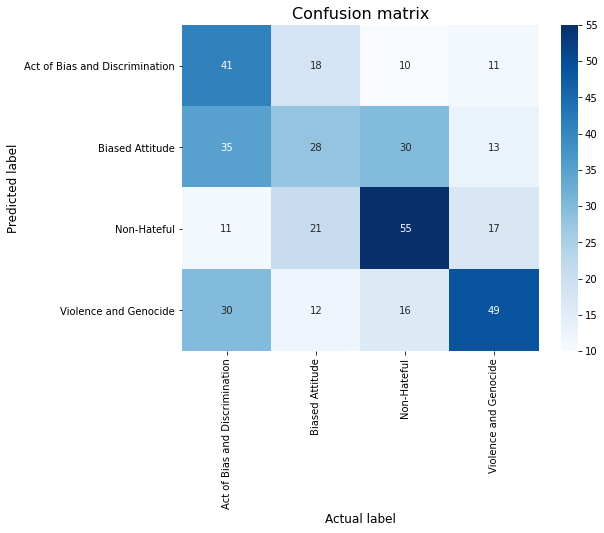

In [148]:
predictions = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
plot_confusion_matrix(xgb_model, X_test, y_test)

In [149]:
print(classification_report(y_test, predictions, target_names=target_names))

                                precision    recall  f1-score   support

Act of Bias and Discrimination       0.35      0.51      0.42        80
               Biased Attitude       0.35      0.26      0.30       106
                   Non-Hateful       0.50      0.53      0.51       104
         Violence and Genocide       0.54      0.46      0.50       107

                      accuracy                           0.44       397
                     macro avg       0.44      0.44      0.43       397
                  weighted avg       0.44      0.44      0.43       397

